### Step 1: Loading the data from Amazon S3

In [ ]:
##Import Libraries

import os
import boto3
import io
import sagemaker

%matplotlib inline 

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
import pickle, gzip, urllib, json
import csv

In [ ]:
## Get IAM role created for notebook instance --'AmazonSageMakerFullAccess' role needed

from sagemaker import get_execution_role
role = get_execution_role()

role

## Starting Boto3 client to interact with AWS Bucket

In [5]:
s3_client = boto3.client('s3')
data_bucket_name='aws-ml-blog-sagemaker-census-segmentation'

## List of Objects within Bucket

In [7]:
obj_list=s3_client.list_objects(Bucket=data_bucket_name)
file=[]
for contents in obj_list['Contents']:
    file.append(contents['Key'])
print(file)
['acs2015_county_data.csv', 'counties/']
file_data=file[0]

['Census_Data_for_SageMaker.csv']


## Get data from CSV file in Bucket

In [8]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
counties = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False) 

## First 5 rows of data

In [9]:
counties.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


### Step 2: Exploratory Data Analysis (EDA)- Data cleaning and Exploration

## Cleaning the data

In [10]:
counties.shape

(3220, 37)

In [12]:
## Drop missing data

counties.dropna(inplace=True)
counties.shape

(3218, 37)

In [13]:
## Combining descriptive columns for Index: 'state-county'

counties.index=counties['State'] + "-" + counties['County']
counties.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [14]:
## Drop Columns

drop=["CensusId", "State", "County"]
counties.drop(drop, axis=1, inplace=True)
counties.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## Visualizing the Data

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


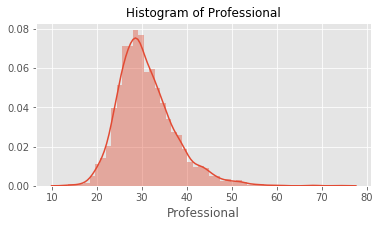

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


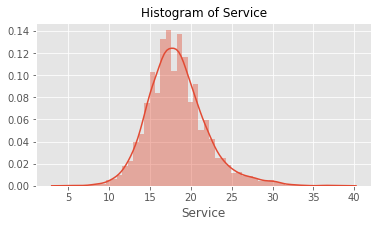

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


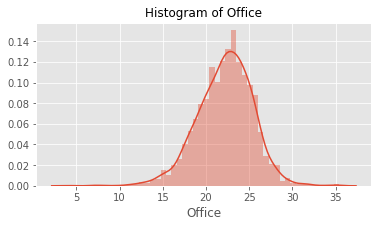

In [38]:
import seaborn as sns

for a in ['Professional', 'Service', 'Office']:
    ax=plt.subplots(figsize=(6,3))
    ax=sns.distplot(counties[a])
    title="Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

In [ ]:
## Indicate Mean and Skew-- A typical county has ~ 25-30% Professional workers, with a right skew,
## long tail and a Prof. worker % max ~ 80% in some counties

In [19]:
## Feature engineering

## minmaxscaler to transform numerical columns to fall between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
counties_scaled = pd.DataFrame(scaler.fit_transform(counties))
counties_scaled.columns = counties.columns
counties_scaled.index = counties.index


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [20]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 3: Data modelling

In [21]:
## Dimensionality reduction using PCA -- http://sagemaker.readthedocs.io/en/latest/pca.html

from sagemaker import PCA
bucket_name= 'census-data-example1'
num_components=33

pca_SM = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path='s3://'+ bucket_name +'/counties/',
            num_components=num_components)

In [27]:
## Extracting numpy array from the DataFrame and explicitly casting to float32

train_data = counties_scaled.values.astype('float32')

In [28]:
## record_set function converts numpy array into record set format needed for Amazon Sagemaker

## Fit function on PCA model, passing in training data, and spinning up a training instance or cluster to perform job


%time
pca_SM.fit(pca_SM.record_set(train_data))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
2020-04-20 00:38:05 Starting - Starting the training job...
2020-04-20 00:38:06 Starting - Launching requested ML instances...
2020-04-20 00:39:05 Starting - Preparing the instances for training......
2020-04-20 00:39:47 Downloading - Downloading input data...
2020-04-20 00:40:29 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/20/2020 00:40:44 INFO 139992907982656] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/20/2020 00:40:44 INFO 139992907982656] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'fea

In [29]:
## Unzipping file with trained model artifacts from S2 Bucket -- Job name found under 'Training Jobs' in Sagemaker

job_name='pca-2020-04-20-00-38-05-377'
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [30]:
## Load ND array using MXNet

import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [32]:
## Three groups of params in PCA model --mean if the 'subtract_mean' hyperparam is true --v: principal components --s: singular values of the comp. for PCA tranformatoin
## explained-varience-ratio ~=square(s)/ sum(square(s))

s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [35]:
## Variance by top 5 largest components ~72% of total variance in data

s.iloc[28:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()


0    0.717983
dtype: float32